# Loop's Temp Basal Logic
description: demonstrate the logic of the loop  
version: 0.0.1  
created: 2018-11-28  
author: Ed Nykaza (forked from the work of [Pete Schwamb](https://github.com/ps2/LoopExplain/blob/master/Loop%20Explain.ipynb))  
license: BSD-2-Clause


In [14]:
# FRONT MATTER
# required magic functions
%matplotlib inline

# required libraries
import os
import numpy as np
import pandas as pd
from scipy.interpolate import BSpline, make_interp_spline
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

# functions
def simulate_cgm_data(cgmTimesMinutes=[5, 120, 240, 360],
                      cgmValues_mgdL=[100, 95, 110, 105],
                      amountOfWiggle=3):

    inputCgm = pd.DataFrame(np.array([cgmTimesMinutes, cgmValues_mgdL]).T, columns=["time", "values"]).sort_values(by="time")
    simulatedTime = np.arange(inputCgm.time.min(), inputCgm.time.max() + 5, 5)
    splineProperties = make_interp_spline(inputCgm["time"].values,
                                          inputCgm["values"].values,
                                          k=amountOfWiggle)
    splineFit = BSpline(splineProperties.t, splineProperties.c, splineProperties.k)
    simulatedCgm = np.round(splineFit(simulatedTime))
    simulatedCgm[simulatedCgm <= 40] = 40
    simulatedCgm[simulatedCgm >= 400] = 400

    return simulatedTime, simulatedCgm


def make_hour_labels(startTimeHour, startTimeAMPM, hourTicks):
    labels = []
    if "AM" in startTimeAMPM:
        ampm = ["AM", "PM"]
    else:
        ampm = ["PM", "AM"]
    for label in hourTicks:
        hr = label + startTimeHour
        if hr == 0:
            hr = 12
            labels.append(("%d " + ampm[1]) % hr)
        elif hr == 12:
            labels.append(("%d " + ampm[1]) % hr)
        elif hr > 12:
            hr = hr - 12
            labels.append(("%d " + ampm[1]) % hr)

        else:  # case of ((hr >= 1) & (hr < 12)):
            labels.append(("%d " + ampm[0]) % hr)

    return labels


In [15]:
# USER INPUTS

# %% specify the CGM Data (in minutes and mg/dL)
cgmTimes = [5, 120, 240, 360]
cgmValues = [100, 95, 110, 105]
simulatedTime, simulatedCgm = simulate_cgm_data(cgmTimes, cgmValues, amountOfWiggle=3)

# specify the time you want the simulation to start
startTimeHour = 6
startTimeAMPM = "AM"


# %% specify the Predicted CGM Values
cgmTimes = [365, 465, 565, 665, 720]
cgmValues = [105, 90, 78, 90, 100]
predictedTime, predictedCgm = simulate_cgm_data(cgmTimes, cgmValues, amountOfWiggle=2)


# %% speficy the correction range
correction_min = 90
correction_max = 120
suspendThreshold = 60
correction_mean = np.mean([correction_min, correction_max])


# %% set figure properties
versionNumber = 1
figureName = "LoopOverviewV" + str(versionNumber)
outputPath = "."
figureSizeInches = (15, 7)
bgRange = [50, 180]

font = {'family': 'normal',
        'weight': 'bold',
        'size': 15}

plt.rc('font', **font)
coord_color = "#c0c0c0"

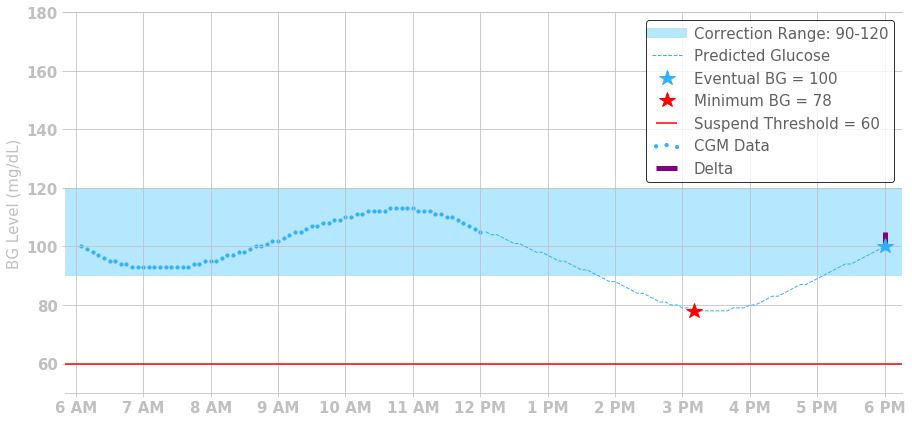

In [16]:
# MAKE AND SAVE THE FIGURE

# define the figure
fig, ax = plt.subplots(figsize=figureSizeInches)
plt.ylim(bgRange)
ax.set_ylabel("BG Level (mg/dL)")
plt.xlim([min(simulatedTime) - 15, max(predictedTime) + 15])

# plot correction range
ax.fill_between([ax.get_xlim()[0], ax.get_xlim()[1]],
                [correction_min, correction_min],
                [correction_max, correction_max],
                facecolor='#B5E7FF', lw=0)

ax.plot([], [], color='#B5E7FF', linewidth=10,
        label="Correction Range: %d-%d" % (correction_min, correction_max))

# plot predicted cgm
ax.plot(predictedTime, predictedCgm, linestyle="--", color="#31B0FF", lw=1, label="Predicted Glucose")

# plot eventual bg
ax.plot(predictedTime[-1], predictedCgm[-1],
        marker='*', markersize=16, color="#31B0FF",
        ls="None", label="Eventual BG = %d" % predictedCgm[-1])

# find and plot minimum BG
min_idx = np.argmin(predictedCgm)
ax.plot(predictedTime[min_idx], predictedCgm[min_idx],
        marker='*', markersize=16, color="red",
        ls="None", label="Minimum BG = %d" % predictedCgm[min_idx])

# plot suspend threshold line
ax.hlines(suspendThreshold, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="red", label="Suspend Threshold = %d" % suspendThreshold)

# plot simulated cgm
ax.scatter(simulatedTime, simulatedCgm, s=10, color="#31B0FF", label="CGM Data")

# plot the delta
ax.vlines(predictedTime[-1], min([correction_mean, predictedCgm[-1]]),
          max([correction_mean, predictedCgm[-1]]), linewidth=5,
          colors="purple", label="Delta")

# define the legend
leg = plt.legend(scatterpoints=3, edgecolor="black")
for text in leg.get_texts():
    text.set_color('#606060')
    text.set_weight('normal')

# set tick marks
minuteTicks = np.arange(0, (len(simulatedTime) + len(predictedTime)) * 5 + 1, 60)
hourTicks = np.int64(minuteTicks / 60)
hourLabels = make_hour_labels(startTimeHour, startTimeAMPM, hourTicks)
ax.set_xticks(minuteTicks)
ax.set_xticklabels(hourLabels)

# set spine and background grid colors
ax.spines['bottom'].set_color(coord_color)
ax.spines['top'].set_color(coord_color)
ax.spines['left'].set_color(coord_color)
ax.spines['right'].set_color(coord_color)
ax.grid(ls='-', color=coord_color)

# turn off the left and right borders
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# set the colors of the labels
ax.xaxis.label.set_color(coord_color)
ax.tick_params(axis='x', colors=coord_color)
ax.yaxis.label.set_color(coord_color)
ax.tick_params(axis='y', colors=coord_color)

# save the figure
plt.savefig(os.path.join(outputPath, figureName + ".png"))
plt.show()
plt.close('all')